# Classification of nail images

In [1]:
from functions import load_images, extract_nail, show_class_examples, generate_augmented_data, cnn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, Dense
from tensorflow.keras.models import model_from_json

### Data

In [2]:
# Load images and their labels
images = []
labels = []
good_images, good_labels = load_images('nailgun/good/')
bad_images, bad_labels = load_images('nailgun/bad/')
images.extend(good_images)
images.extend(bad_images)
labels.extend(good_labels)
labels.extend(bad_labels)

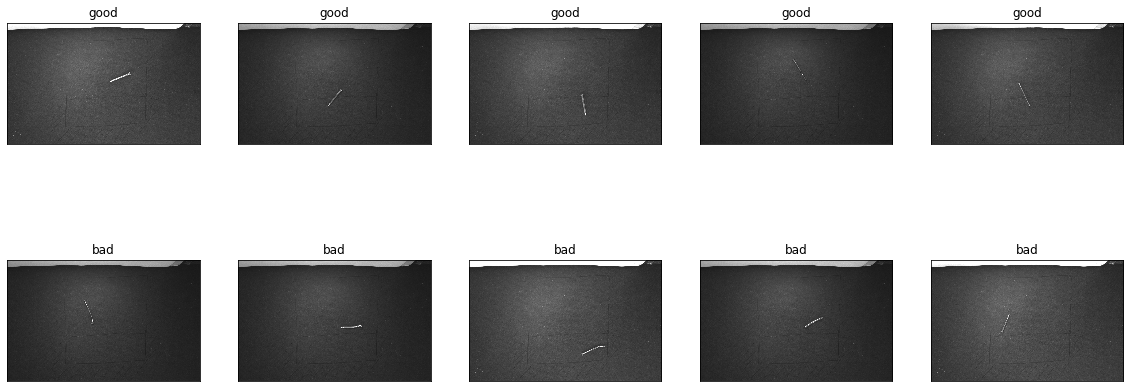

In [3]:
# Examples of good and bad nails
show_class_examples(good_images[:5], bad_images[:5], 'good', 'bad')

### The nail takes up a very small part of the image, so we extract the part with the nail

In [4]:
images_cropped = [extract_nail(img) for img in images]

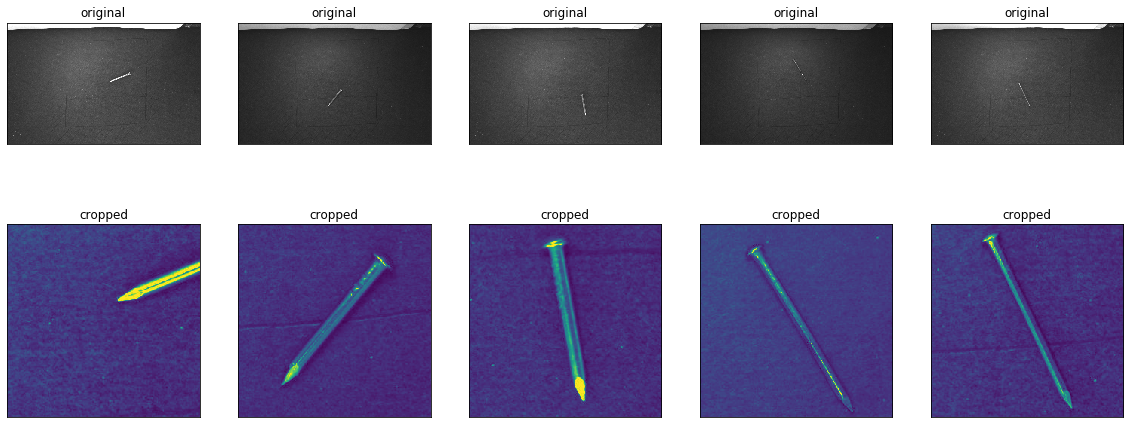

In [5]:
show_class_examples(images[:5], images_cropped[:5], 'original', 'cropped')

In [6]:
# Resize images so they are smaller and all have the same shape. A few don't have a usable shape
resized = []
resized_labels = []
for i in range(len(images_cropped)):
    try:
        resized.append(cv2.resize(images_cropped[i], dsize=(128, 128), interpolation=cv2.INTER_CUBIC))
        resized_labels.append(labels[i])
    except:
        continue

resized = np.array(resized)
resized_labels = to_categorical(resized_labels)

### The dataset is very small (99 images per class), so we do some offline data augmentation
- Flip horizontally and vertically
- Rotate 90, 180, and 270 degrees

In [7]:
# First split data into train, val, and test, so only train images are used for data augmentation
X_train, X_test, y_train, y_test = train_test_split(resized, resized_labels, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
print('X_train: {}'.format(X_train.shape))
print('y_train: {}'.format(y_train.shape))
print('X_test: {}'.format(X_test.shape))
print('y_test: {}'.format(y_test.shape))
print('X_val: {}'.format(X_val.shape))
print('y_val: {}'.format(y_val.shape))

X_train: (124, 128, 128)
y_train: (124, 2)
X_test: (40, 128, 128)
y_test: (40, 2)
X_val: (32, 128, 128)
y_val: (32, 2)


In [8]:
aug_images, aug_labels = generate_augmented_data(X_train, y_train)

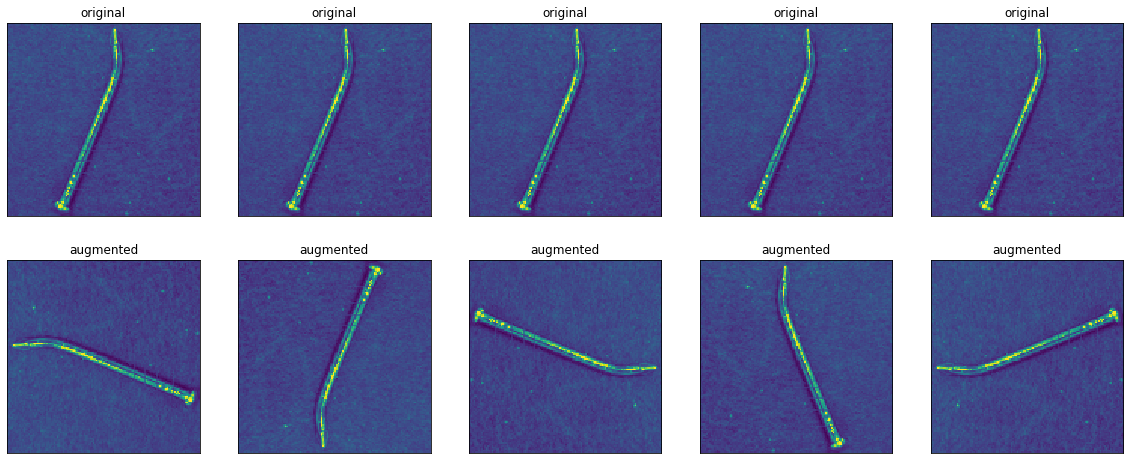

In [9]:
show_class_examples([X_train[0]]*5, aug_images[:5], 'original', 'augmented')

In [10]:
X_train = np.concatenate((X_train, aug_images))
y_train = np.concatenate((y_train, aug_labels))

In [11]:
X_train = X_train.reshape(X_train.shape[0],128,128,1)
X_val = X_val.reshape(X_val.shape[0],128,128,1)
X_test = X_test.reshape(X_test.shape[0],128,128,1)

In [12]:
print('X_train: {}'.format(X_train.shape))
print('y_train: {}'.format(y_train.shape))

X_train: (1488, 128, 128, 1)
y_train: (1488, 2)


### CNN model for classification

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)))
model.add(Conv2D(32, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['acc'])

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

In [ ]:
model.evaluate(X_test,y_test)

In [ ]:
model.save('model.h5')
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)